#  Dataset Preparation

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Translation dictionary for folder names
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "scoiattolo": "squirrel", "dog": "cane", "horse": "cavallo",
    "elephant": "elefante", "butterfly": "farfalla", "chicken": "gallina",
    "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"
}

# Paths to the dataset
original_dataset_dir = "./raw-img"
base_dir = "./dataset"  # Directory for organized dataset

# Create directories for train, val, test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


def prepare_dataset():
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
        os.mkdir(train_dir)
        os.mkdir(val_dir)
        os.mkdir(test_dir)

    # Process each class folder
    for folder in os.listdir(original_dataset_dir):
        folder_path = os.path.join(original_dataset_dir, folder)
        if os.path.isdir(folder_path):
            # Translate folder name
            class_name = translate.get(folder, folder)
            train_class_dir = os.path.join(train_dir, class_name)
            val_class_dir = os.path.join(val_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)

            # Create class subfolders
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            # Get list of all images
            images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.jpeg')]

            # Split into train, val, test
            train, test = train_test_split(images, test_size=0.2, random_state=42)
            train, val = train_test_split(train, test_size=0.125, random_state=42)  # 10% of total for val

            # Copy images to respective folders
            for img in train:
                shutil.copy(img, train_class_dir)
            for img in val:
                shutil.copy(img, val_class_dir)
            for img in test:
                shutil.copy(img, test_class_dir)


prepare_dataset()


In [4]:
import os
import shutil
# Paths to the dataset
original_dataset_dir = "./raw-img"
base_dir = "./dataset"  # Directory for organized dataset

# Create directories for train, val, test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Model Design and Training

## CNN Model Design

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMG_SIZE = (128, 128)  # Resize images to 128x128
BATCH_SIZE = 32
NUM_CLASSES = 10

def create_model():
    model = models.Sequential([
        # Convolutional Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Convolutional Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Convolutional Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Flatten and Fully Connected Layer
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

## Data Augmentation and Generators

In [5]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalize for validation and test

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # For consistent test results
)


Found 16938 images belonging to 10 classes.
Found 2425 images belonging to 10 classes.
Found 4846 images belonging to 10 classes.


## Training the Model

In [6]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Training
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Epoch 1/20
530/530 [==============================] - 524s 975ms/step - loss: 2.1398 - accuracy: 0.2220 - val_loss: 1.9184 - val_accuracy: 0.3295
Epoch 2/20
530/530 [==============================] - 224s 422ms/step - loss: 1.9448 - accuracy: 0.3105 - val_loss: 1.7066 - val_accuracy: 0.4214
Epoch 3/20
530/530 [==============================] - 241s 454ms/step - loss: 1.8022 - accuracy: 0.3726 - val_loss: 1.7012 - val_accuracy: 0.4219
Epoch 4/20
530/530 [==============================] - 243s 458ms/step - loss: 1.6851 - accuracy: 0.4169 - val_loss: 1.5097 - val_accuracy: 0.4845
Epoch 5/20
530/530 [==============================] - 247s 466ms/step - loss: 1.6227 - accuracy: 0.4401 - val_loss: 1.5771 - val_accuracy: 0.4528
Epoch 6/20
530/530 [==============================] - 248s 467ms/step - loss: 1.5816 - accuracy: 0.4606 - val_loss: 1.3883 - val_accuracy: 0.5249
Epoch 7/20
530/530 [==============================] - 246s 464ms/step - loss: 1.5272 - accuracy: 0.4742 - val_loss: 1.3648 -

## Evaluation

152/152 [==============================] - 19s 127ms/step - loss: 1.2676 - accuracy: 0.5565
Test Loss: 1.2676246166229248
Test Accuracy: 0.5565415024757385


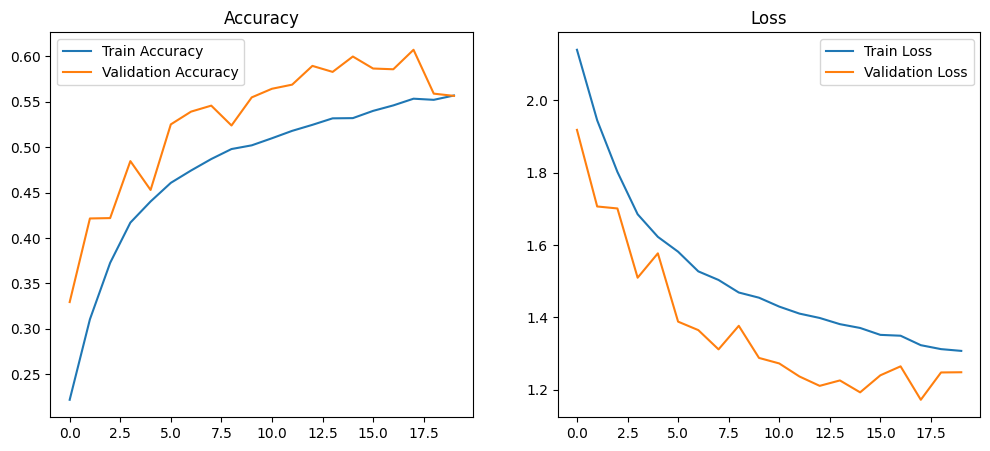

152/152 [==============================] - 15s 100ms/step
Classification Report:
               precision    recall  f1-score   support

   butterfly       0.78      0.74      0.76       330
         cat       0.33      0.01      0.02       246
     chicken       0.38      0.95      0.54       620
         cow       0.53      0.28      0.36       374
         dog       0.69      0.44      0.53       973
    elephant       0.49      0.60      0.54       216
       horse       0.53      0.62      0.57       525
       ragno       0.79      0.75      0.77       900
       sheep       0.42      0.38      0.40       289
    squirrel       0.59      0.25      0.35       373

    accuracy                           0.56      4846
   macro avg       0.55      0.50      0.48      4846
weighted avg       0.59      0.56      0.54      4846



In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot Learning Curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_learning_curves(history)

# Generate classification report and confusion matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
